In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Reload uamocf submodules to pick up any changes
import uamocf.models
import uamocf.visualization
import uamocf.data
import uamocf.cf_problem
import uamocf.optimization
importlib.reload(uamocf.models)
importlib.reload(uamocf.visualization)
importlib.reload(uamocf.data)
importlib.reload(uamocf.cf_problem)
importlib.reload(uamocf.optimization)
import uamocf
importlib.reload(uamocf)

from uamocf import (
    # Data
    MNISTConfig,
    get_mnist_images_subset,
    
    # Models
    MNISTClassifier,
    EnsembleModel,
    
    # Training
    MNISTTrainConfig,
    train_mnist_ensemble,
    train_image_model,
    extract_models,
    
    # Counterfactual problem
    ImageCFConfig,
    make_cf_problem_image_space,
    
    # Optimization
    NSGAConfig,
    run_nsga2,
    FactualBasedSampling,  # For initializing population around factual
    
    # Uncertainty
    compute_uncertainty_decomposition,
    
    # Visualization
    visualize_image_counterfactuals,
    plot_pareto_front_2d,
)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Load and Prepare MNIST Data

We use **downsampled 16×16 images** (instead of 28×28) to make optimization faster.
This reduces the search space from 784 to 256 dimensions.

In [2]:
from torchvision import datasets, transforms

# Configuration
IMG_SIZE = 16  # Downsampled for faster optimization
N_TRAIN = 5000  # Training samples per model
N_ENSEMBLE = 5  # Number of models in ensemble

# Transform: resize to 16x16 and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image size: {IMG_SIZE}×{IMG_SIZE} = {IMG_SIZE**2} pixels")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 286kB/s]

100%|██████████| 1.65M/1.65M [00:00<00:00, 2.36MB/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 357kB/s]

Training samples: 60000
Test samples: 10000
Image size: 16×16 = 256 pixels


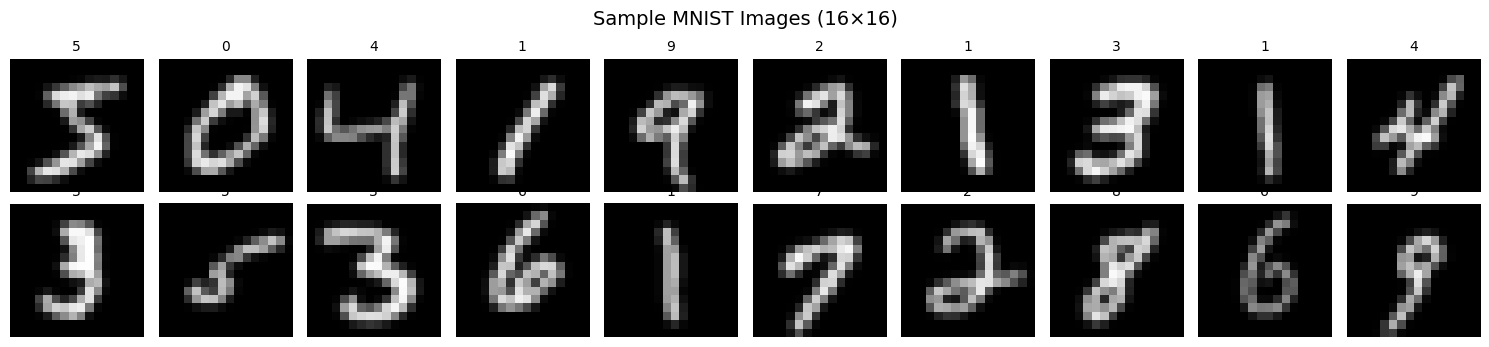

In [3]:
# Visualize some sample images
fig, axes = plt.subplots(2, 10, figsize=(15, 3.5))

for i in range(20):
    ax = axes[i // 10, i % 10]
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().numpy(), cmap='gray', vmin=-1, vmax=1)
    ax.set_title(f'{label}', fontsize=10)
    ax.axis('off')

plt.suptitle(f'Sample MNIST Images ({IMG_SIZE}×{IMG_SIZE})', fontsize=14)
plt.tight_layout()
plt.show()

## 2. Train MNIST Ensemble

Train an ensemble of CNN classifiers for digit recognition.
Each model is trained on a different data sample for diversity.

In [4]:
# Create test loader for evaluation
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Function to sample training data for each model
def sample_mnist_data(n_samples: int, seed: int):
    """Sample a subset of MNIST training data."""
    rng = np.random.default_rng(seed)
    indices = rng.choice(len(train_dataset), size=n_samples, replace=False)
    
    images = []
    labels = []
    for idx in indices:
        img, label = train_dataset[idx]
        images.append(img.numpy())
        labels.append(label)
    
    return np.array([0]), np.array(labels), np.array([0]), np.array(images)

# Training configuration
train_config = MNISTTrainConfig(
    epochs=5,
    batch_size=64,
    lr=1e-3,
    img_size=IMG_SIZE,
    seed=42,
)

print(f"Training ensemble of {N_ENSEMBLE} models...")
print(f"Each model trained on {N_TRAIN} images")
print(f"Epochs per model: {train_config.epochs}")
print("="*60)

Training ensemble of 5 models...
Each model trained on 5000 images
Epochs per model: 5


In [5]:
# Train ensemble
train_results = train_mnist_ensemble(
    num_models=N_ENSEMBLE,
    mnist_dpg_fn=sample_mnist_data,
    test_loader=test_loader,
    cfg=train_config,
    n_samples_per_model=N_TRAIN,
)

# Extract models
models = extract_models(train_results)
ensemble = EnsembleModel(models)

# Summary
accuracies = [r.val_accuracy for r in train_results]
print(f"\n✓ Ensemble trained!")
print(f"  Test accuracies: {[f'{acc:.2%}' for acc in accuracies]}")
print(f"  Mean accuracy: {np.mean(accuracies):.2%}")

Training Deep Ensemble with 5 models
Each model trained on 5000 images

--- Training Model 1/5 ---
  Data sampling seed: 42
  Model init seed: 1000
  Data sampling seed: 42
  Model init seed: 1000


Training: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  3.02epoch/s, Loss=0.3852]



  Test Accuracy: 94.05%

--- Training Model 2/5 ---
  Data sampling seed: 165
  Model init seed: 2000
  Data sampling seed: 165
  Model init seed: 2000


Training: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  4.34epoch/s, Loss=0.2914]



  Test Accuracy: 94.71%

--- Training Model 3/5 ---
  Data sampling seed: 288
  Model init seed: 3000
  Data sampling seed: 288
  Model init seed: 3000


Training: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  4.17epoch/s, Loss=0.2630]



  Test Accuracy: 94.78%

--- Training Model 4/5 ---
  Data sampling seed: 411
  Model init seed: 4000
  Data sampling seed: 411
  Model init seed: 4000


Training: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  3.91epoch/s, Loss=0.2728]



  Test Accuracy: 95.34%

--- Training Model 5/5 ---
  Data sampling seed: 534
  Model init seed: 5000
  Data sampling seed: 534
  Model init seed: 5000


Training: 100%|███████████████████████████████████████| 5/5 [00:01<00:00,  3.49epoch/s, Loss=0.2418]



  Test Accuracy: 95.41%

Ensemble Training Complete!

✓ Ensemble trained!
  Test accuracies: ['94.05%', '94.71%', '94.78%', '95.34%', '95.41%']
  Mean accuracy: 94.86%


## 3. Select a Factual Instance

Choose a digit that we want to transform into a different digit.
Let's select a **7** and try to transform it into a **1** (a plausible transformation).

In [6]:
# Find images of digit 7 in the test set
FACTUAL_DIGIT = 7
TARGET_DIGIT = 1

digit_indices = [i for i in range(len(test_dataset)) if test_dataset[i][1] == FACTUAL_DIGIT]
print(f"Found {len(digit_indices)} images of digit {FACTUAL_DIGIT}")

# Select one as our factual
factual_idx = digit_indices[5]  # Pick one
factual_img, factual_label = test_dataset[factual_idx]
factual_img_np = factual_img.numpy().squeeze()  # Shape: (16, 16)

print(f"\nSelected factual image index: {factual_idx}")
print(f"True label: {factual_label}")
print(f"Target digit for counterfactual: {TARGET_DIGIT}")

Found 1028 images of digit 7

Selected factual image index: 41
True label: 7
Target digit for counterfactual: 1


In [7]:
# Get model prediction for factual
ensemble.models[0].eval()

factual_tensor = factual_img.unsqueeze(0).to(device)
with torch.no_grad():
    logits = ensemble.models[0](factual_tensor)
    probs_factual = nn.Softmax(dim=1)(logits).cpu().numpy()[0]

pred_class = np.argmax(probs_factual)

print(f"Model prediction: {pred_class} (P={probs_factual[pred_class]:.4f})")
print(f"P(target={TARGET_DIGIT}): {probs_factual[TARGET_DIGIT]:.4f}")
print(f"\nAll class probabilities:")
for d in range(10):
    bar = '█' * int(probs_factual[d] * 20)
    print(f"  {d}: {probs_factual[d]:.4f} {bar}")

Model prediction: 7 (P=0.9701)
P(target=1): 0.0004

All class probabilities:
  0: 0.0002 
  1: 0.0004 
  2: 0.0091 
  3: 0.0052 
  4: 0.0000 
  5: 0.0001 
  6: 0.0000 
  7: 0.9701 ███████████████████
  8: 0.0007 
  9: 0.0141 


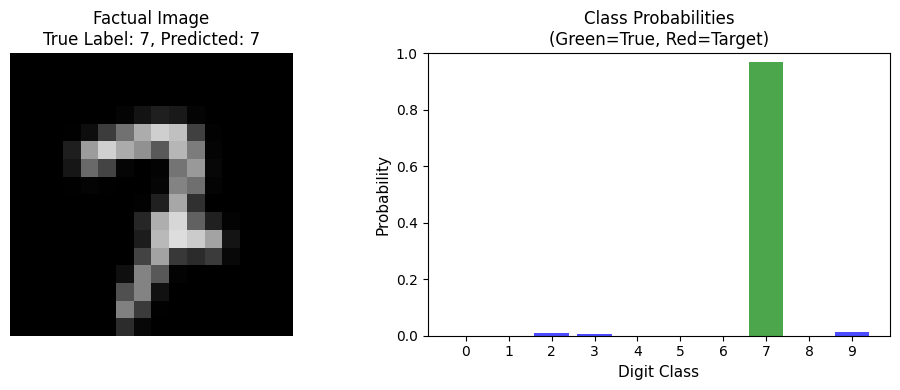

In [8]:
# Visualize the factual image
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Image
axes[0].imshow(factual_img_np, cmap='gray', vmin=-1, vmax=1)
axes[0].set_title(f'Factual Image\nTrue Label: {factual_label}, Predicted: {pred_class}', fontsize=12)
axes[0].axis('off')

# Probability bar chart
colors = ['green' if d == factual_label else 'red' if d == TARGET_DIGIT else 'blue' for d in range(10)]
axes[1].bar(range(10), probs_factual, color=colors, alpha=0.7)
axes[1].set_xlabel('Digit Class', fontsize=11)
axes[1].set_ylabel('Probability', fontsize=11)
axes[1].set_title('Class Probabilities\n(Green=True, Red=Target)', fontsize=12)
axes[1].set_xticks(range(10))
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 4. Generate Image-Space Counterfactuals

Use NSGA-II to optimize in the 256-dimensional pixel space.
The optimizer will find images that:
1. Are classified as the target digit
2. Are visually similar to the factual
3. Have desirable uncertainty properties

In [9]:
# Get some observed images for plausibility (optional)
X_obs_images, _, _ = get_mnist_images_subset(train_dataset, n_samples=500, seed=42)
print(f"Observed images for plausibility: {X_obs_images.shape}")

Observed images for plausibility: (500, 16, 16)


In [10]:
# Create image-space CF problem
cf_config = ImageCFConfig(
    img_size=IMG_SIZE,
    pixel_range=(-1.0, 1.0),  # Normalized range
    sparsity_eps=0.05,  # Threshold for "changed" pixel
    k_neighbors=5,
)

problem = make_cf_problem_image_space(
    model=ensemble.models[0],
    x_star_image=factual_img_np,
    target_class=TARGET_DIGIT,
    X_obs_images=X_obs_images,
    ensemble=ensemble.models,
    config=cf_config,
    device=device,
)

print(f"\nCF Problem Setup:")
print(f"  Decision variables: {problem.n_var} (pixels)")
print(f"  Objectives: {problem.n_obj}")
print(f"  Pixel bounds: [{cf_config.pixel_range[0]}, {cf_config.pixel_range[1]}]")

Objectives: [Validity, Sparsity, AU (max), EU (min)]

CF Problem Setup:
  Decision variables: 256 (pixels)
  Objectives: 4
  Pixel bounds: [-1.0, 1.0]


In [ ]:
# Configure NSGA-II
# Note: Image-space optimization is more challenging, so we use more generations
nsga_config = NSGAConfig(
    pop_size=400,     # Population size
    min_valid_cf=150,
    min_gen=500,
    max_gen=1550,       # More generations for image space
    verbose=True,
)

print(f"Running NSGA-II optimization...")
print(f"  Population: {nsga_config.pop_size}")
print(f"  Generations: {nsga_config.n_gen}")
print(f"  Total evaluations: ~{nsga_config.pop_size * nsga_config.n_gen}")
print()

Running NSGA-II optimization...
  Population: 300
  Generations: 200
  Total evaluations: ~60000



In [14]:
# Create factual-based sampling to initialize population near the factual image
sampling = FactualBasedSampling(
    x_star=factual_img_np.flatten(),
    noise_scale=0.7,  # Perturbation scale (as fraction of pixel range)
)

# Run optimization with factual-based sampling
result = run_nsga2(
    problem=problem,
    config=nsga_config,
    sampling=sampling,  # Use factual-based initialization
)

print(f"\n✓ Optimization complete!")
print(f"  Found {len(result.X)} counterfactual candidates")

Gen    1 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.011 | Mean Sparsity: 0.521
Gen   10 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.036 | Mean Sparsity: 0.493
Gen   20 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.077 | Mean Sparsity: 0.472
Gen   30 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.146 | Mean Sparsity: 0.455
Gen   40 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.184 | Mean Sparsity: 0.447
Gen   50 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.221 | Mean Sparsity: 0.432
Gen   60 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.236 | Mean Sparsity: 0.422
Gen   70 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.287 | Mean Sparsity: 0.418
Gen   80 | Valid CFs (pop):   0 | Valid CFs (archive):   0 | Best P(target): 0.318 | Mean Sparsity: 0.408
Gen   90 | Valid CFs (pop):   0 | Valid CFs (a

## 5. Analyze and Visualize Results

Examine the generated counterfactuals in both objective space and image space.

In [15]:
# Separate valid and invalid counterfactuals
# Objective 0 is invalidity (1 - P(target)), so < 0.5 means valid
validity = result.F[:, 0]
valid_mask = validity < 0.5
invalid_mask = ~valid_mask

valid_cfs = result.X[valid_mask]
invalid_cfs = result.X[invalid_mask]
valid_F = result.F[valid_mask]
invalid_F = result.F[invalid_mask]

print(f"Results Summary:")
print(f"  Total CFs: {len(result.X)}")
print(f"  Valid CFs (P(target) > 0.5): {len(valid_cfs)}")
print(f"  Invalid CFs (P(target) ≤ 0.5): {len(invalid_cfs)}")

Results Summary:
  Total CFs: 300
  Valid CFs (P(target) > 0.5): 71
  Invalid CFs (P(target) ≤ 0.5): 229


In [16]:
# 3D Pareto front visualization
import plotly.graph_objects as go

if result.F is not None and len(result.F) > 0:
    # Evaluate factual in objective space
    F_factual = problem.evaluate(factual_img_np.flatten().astype(np.float32))
    
    # Objective order: [0] Validity, [1] Sparsity, [2] AU (negated), [3] EU (positive)
    # For display: negate AU back to positive, EU is already positive
    
    fig = go.Figure()
    
    # Invalid CFs (blue)
    if len(invalid_F) > 0:
        fig.add_trace(go.Scatter3d(
            x=invalid_F[:, 3],      # EU (positive, minimize)
            y=invalid_F[:, 0],      # Validity (1-P)
            z=-invalid_F[:, 2],     # AU (negate back to positive for display)
            mode='markers',
            marker=dict(color='blue', size=4, opacity=0.5, symbol='cross'),
            name=f'Invalid CFs (n={len(invalid_F)})'
        ))
    
    # Valid CFs (red)
    if len(valid_F) > 0:
        fig.add_trace(go.Scatter3d(
            x=valid_F[:, 3],        # EU (positive, minimize)
            y=valid_F[:, 0],        # Validity (1-P)
            z=-valid_F[:, 2],       # AU (negate back to positive for display)
            mode='markers',
            marker=dict(color='red', size=5, symbol='cross'),
            name=f'Valid CFs (n={len(valid_F)})'
        ))
    
    # Factual (purple)
    fig.add_trace(go.Scatter3d(
        x=[F_factual[3]],           # EU
        y=[F_factual[0]],           # Validity
        z=[-F_factual[2]],          # AU (negated for display)
        mode='markers',
        marker=dict(color='purple', size=8),
        name='Factual x*'
    ))
    
    fig.update_layout(
        scene=dict(
            xaxis_title='Epistemic Uncertainty (minimize)',
            yaxis_title='Invalidity (1-P(target))',
            zaxis_title='Aleatoric Uncertainty (maximize)',
        ),
        width=800, height=600,
        title=f'MNIST Pareto Front: Digit {factual_label} → {TARGET_DIGIT}'
    )
    
    fig.show()

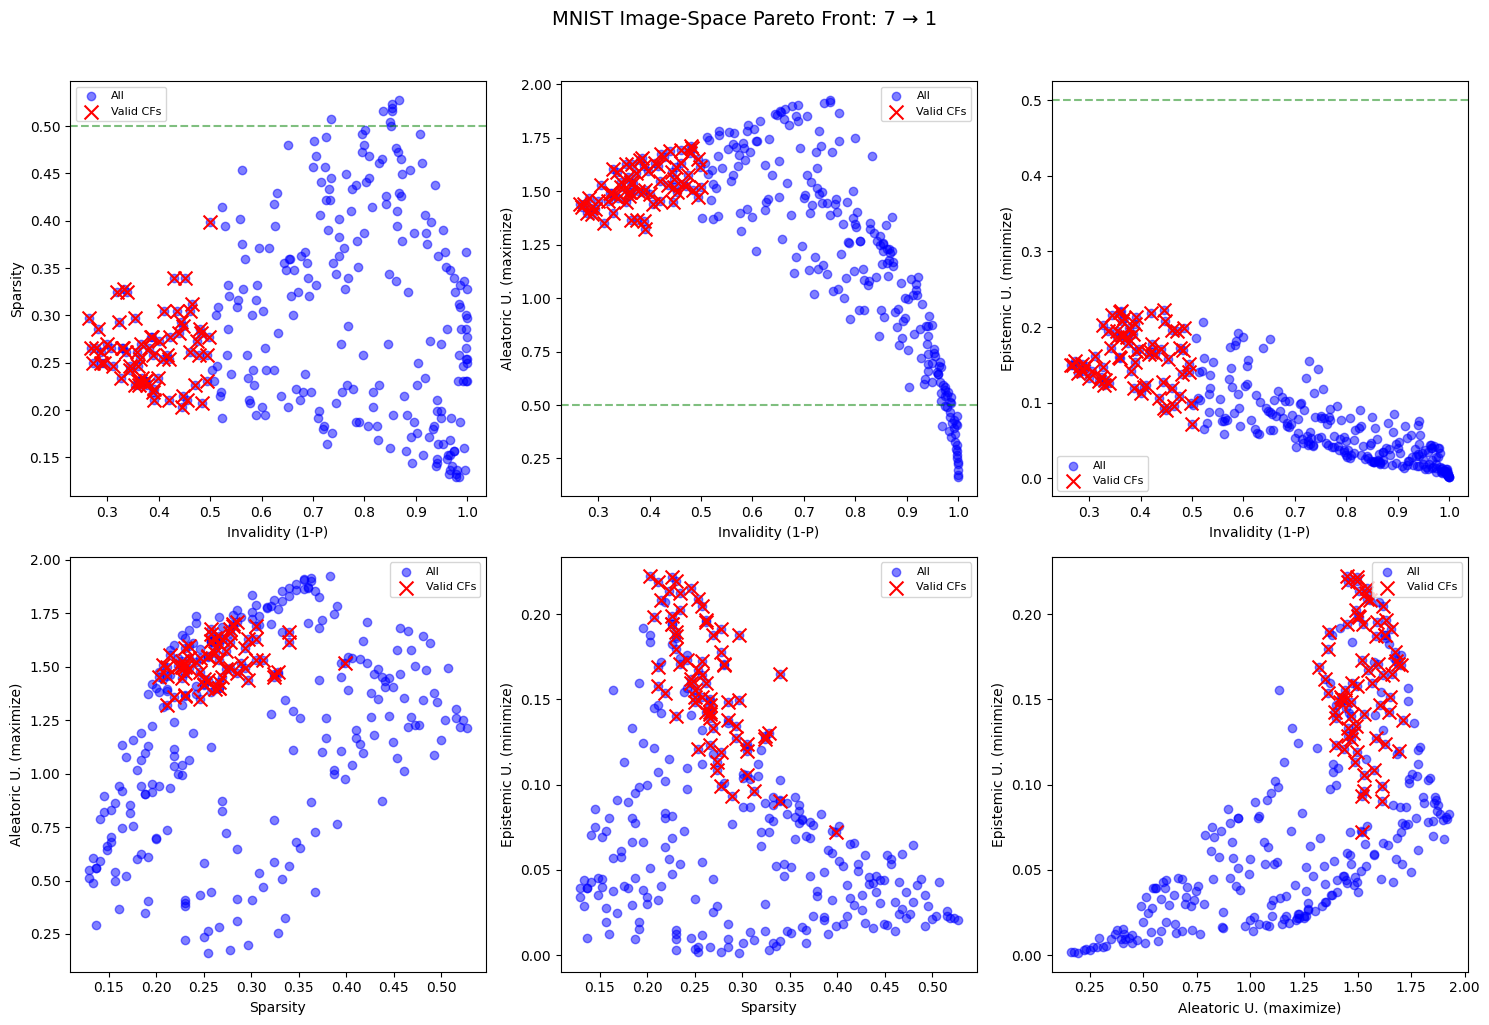

In [17]:
# 2D Pareto front projections
if result.F is not None and len(result.F) > 0:
    # Transform AU back to positive for display
    # Objective order: [0] Validity, [1] Sparsity, [2] AU (negated), [3] EU (positive)
    F_display = result.F.copy()
    F_display[:, 2] = -F_display[:, 2]  # Negate AU back to positive
    
    valid_F_display = valid_F.copy() if len(valid_F) > 0 else None
    if valid_F_display is not None:
        valid_F_display[:, 2] = -valid_F_display[:, 2]  # Negate AU
    
    obj_names = ['Invalidity (1-P)', 'Sparsity', 'Aleatoric U. (maximize)', 'Epistemic U. (minimize)']
    
    fig, axes = plot_pareto_front_2d(
        F_display,
        F_valid=valid_F_display,
        objective_names=obj_names,
        figsize=(15, 10),
    )
    
    fig.suptitle(f'MNIST Image-Space Pareto Front: {factual_label} → {TARGET_DIGIT}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

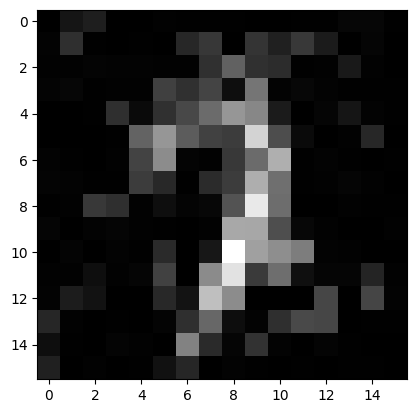

In [18]:
result.X[0].reshape(IMG_SIZE, IMG_SIZE)
plt.imshow(result.X[99].reshape(IMG_SIZE, IMG_SIZE), cmap='gray', vmin=-1, vmax=1)

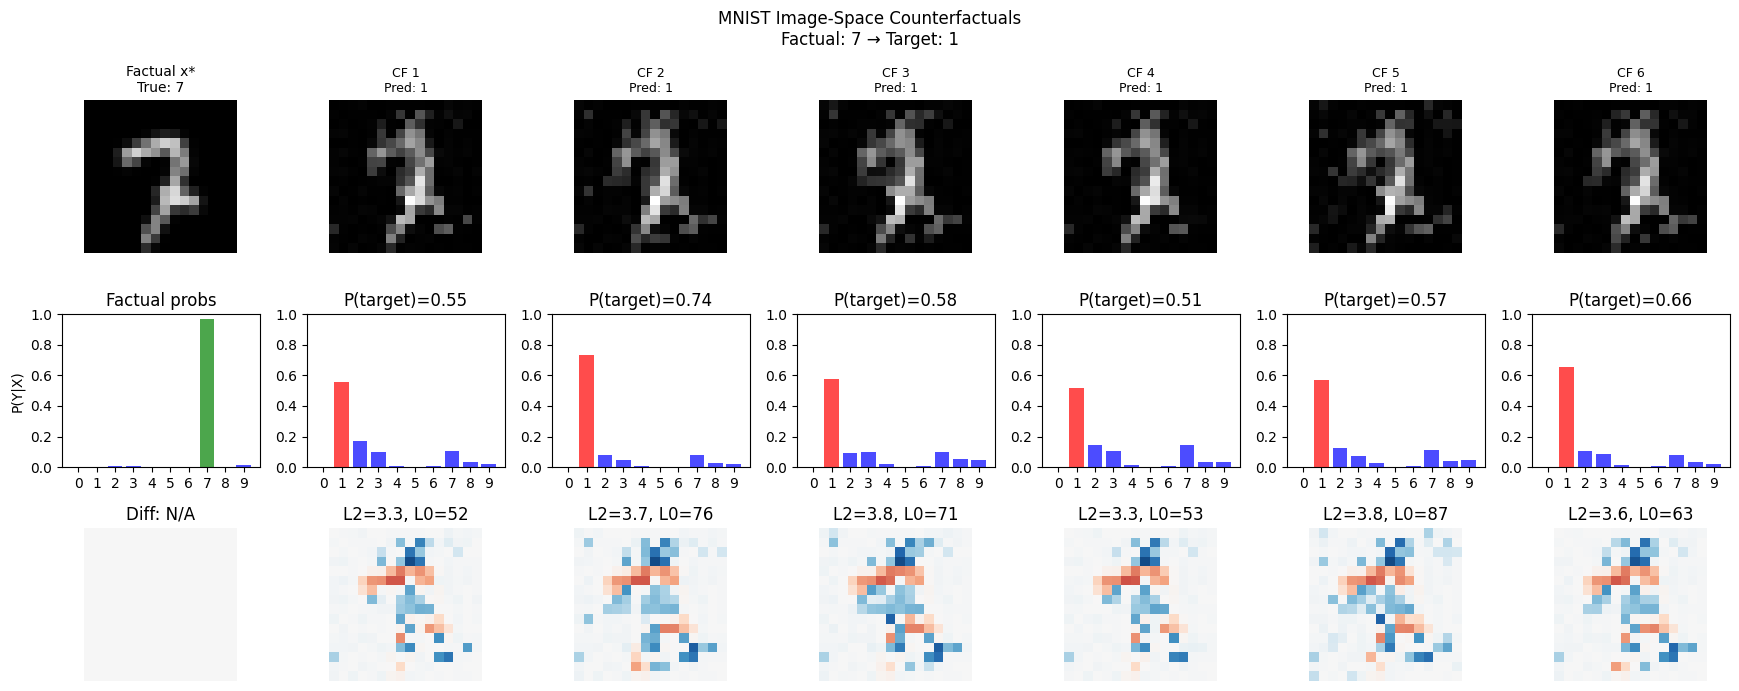

: 

In [ ]:
# Visualize counterfactual images using the library function
if len(valid_cfs) > 0:
    fig = visualize_image_counterfactuals(
        model=ensemble.models[0],
        x_star_image=factual_img_np,
        cf_images=valid_cfs,
        target_class=TARGET_DIGIT,
        factual_label=factual_label,
        device=device,
        img_size=IMG_SIZE,
        n_show=6,  # Show up to 6 CFs
    )
    plt.show()
else:
    print("No valid counterfactuals found. Try increasing generations or population size.")

## 6. Detailed Analysis of Best Counterfactuals

Examine the most promising counterfactuals in detail.

In [ ]:
# Find the best valid CF (highest validity)
if len(valid_cfs) > 0:
    # Sort by validity (lower is better - it's 1-P(target))
    sorted_idx = np.argsort(valid_F[:, 0])
    
    print("Top 5 Valid Counterfactuals:")
    print("=" * 60)
    
    for rank, idx in enumerate(sorted_idx[:5]):
        cf_flat = valid_cfs[idx]
        cf_img = cf_flat.reshape(IMG_SIZE, IMG_SIZE)
        
        # Get model prediction
        cf_tensor = torch.tensor(cf_flat.reshape(1, 1, IMG_SIZE, IMG_SIZE), dtype=torch.float32).to(device)
        with torch.no_grad():
            probs_cf = nn.Softmax(dim=1)(ensemble.models[0](cf_tensor)).cpu().numpy()[0]
        
        pred = np.argmax(probs_cf)
        
        # Compute metrics
        diff = cf_img - factual_img_np
        l2_dist = np.linalg.norm(diff)
        l0_changes = np.sum(np.abs(diff) > 0.05)
        
        print(f"\nRank {rank+1}:")
        print(f"  P(target={TARGET_DIGIT}): {probs_cf[TARGET_DIGIT]:.4f}")
        print(f"  Predicted class: {pred}")
        print(f"  L2 distance: {l2_dist:.4f}")
        print(f"  Changed pixels (L0): {l0_changes} / {IMG_SIZE**2}")
else:
    print("No valid counterfactuals to analyze.")

In [ ]:
# Visualize the best CF with pixel-level detail
if len(valid_cfs) > 0:
    best_idx = np.argmin(valid_F[:, 0])  # Best validity
    best_cf = valid_cfs[best_idx].reshape(IMG_SIZE, IMG_SIZE)
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Factual
    axes[0].imshow(factual_img_np, cmap='gray', vmin=-1, vmax=1)
    axes[0].set_title(f'Factual (digit {factual_label})', fontsize=12)
    axes[0].axis('off')
    
    # Best CF
    axes[1].imshow(best_cf, cmap='gray', vmin=-1, vmax=1)
    cf_tensor = torch.tensor(best_cf.reshape(1, 1, IMG_SIZE, IMG_SIZE), dtype=torch.float32).to(device)
    with torch.no_grad():
        probs = nn.Softmax(dim=1)(ensemble.models[0](cf_tensor)).cpu().numpy()[0]
    pred = np.argmax(probs)
    axes[1].set_title(f'Best CF (pred: {pred}, P={probs[TARGET_DIGIT]:.3f})', fontsize=12)
    axes[1].axis('off')
    
    # Difference
    diff = best_cf - factual_img_np
    im = axes[2].imshow(diff, cmap='RdBu', vmin=-1, vmax=1)
    axes[2].set_title('Difference (CF - Factual)', fontsize=12)
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    
    # Absolute change
    abs_diff = np.abs(diff)
    im2 = axes[3].imshow(abs_diff, cmap='hot', vmin=0, vmax=1)
    axes[3].set_title(f'|Change| (L0={np.sum(abs_diff > 0.05)})', fontsize=12)
    axes[3].axis('off')
    plt.colorbar(im2, ax=axes[3], fraction=0.046, pad=0.04)
    
    plt.suptitle(f'Best Counterfactual: {factual_label} → {TARGET_DIGIT}', fontsize=14)
    plt.tight_layout()
    plt.show()

## 7. Try Different Digit Transformations

Let's try a few more transformations to see how the CFs differ.

In [ ]:
# Try transforming 3 → 8 (another plausible transformation)
TARGET_2 = 8
FACTUAL_2 = 3

# Find a 3
digit_3_indices = [i for i in range(len(test_dataset)) if test_dataset[i][1] == FACTUAL_2]
factual_2_idx = digit_3_indices[3]
factual_2_img, factual_2_label = test_dataset[factual_2_idx]
factual_2_img_np = factual_2_img.numpy().squeeze()

print(f"\nNew factual: digit {factual_2_label}")
print(f"Target: digit {TARGET_2}")

In [ ]:
# Generate CFs for 3→8
problem_2 = make_cf_problem_image_space(
    model=ensemble.models[0],
    x_star_image=factual_2_img_np,
    target_class=TARGET_2,
    X_obs_images=X_obs_images,
    ensemble=ensemble.models,
    config=cf_config,
    device=device,
)

result_2 = run_nsga2(
    problem=problem_2,
    config=NSGAConfig(pop_size=50, n_gen=80, verbose=True),
)

# Check results
validity_2 = result_2.F[:, 0]
valid_mask_2 = validity_2 < 0.5
valid_cfs_2 = result_2.X[valid_mask_2]

print(f"\n✓ Found {len(valid_cfs_2)} valid CFs for {FACTUAL_2}→{TARGET_2}")

In [ ]:
# Visualize the 3→8 counterfactuals
if len(valid_cfs_2) > 0:
    fig = visualize_image_counterfactuals(
        model=ensemble.models[0],
        x_star_image=factual_2_img_np,
        cf_images=valid_cfs_2,
        target_class=TARGET_2,
        factual_label=factual_2_label,
        device=device,
        img_size=IMG_SIZE,
        n_show=6,
    )
    plt.show()
else:
    print("No valid CFs found for this transformation.")

## Summary

This demo showed how to:

1. **Load and prepare MNIST data** with downsampling for faster optimization
2. **Train a CNN ensemble** for uncertainty-aware digit classification
3. **Generate image-space counterfactuals** by optimizing directly in pixel space
4. **Visualize results** including:
   - 3D Pareto fronts showing objective trade-offs
   - Counterfactual images with probability distributions
   - Pixel-level change analysis
5. **Try different digit transformations** to see how CFs vary

### Key Insights for Image-Space CFs

- **High-dimensional optimization**: 256 variables (16×16 pixels) is challenging but feasible
- **Sparse changes**: Many CFs achieve class flipping with localized pixel modifications
- **Interpretable perturbations**: The difference images show which pixels matter for classification
- **Plausibility trade-offs**: CFs that look more like real digits may require more changes
- **Digit similarity**: Transformations between visually similar digits (7→1, 3→8) tend to require fewer changes